### А/А-тестирование мобильного приложения. 
Необходимо посчитать результаты A/A-теста,проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

#### Описание колонок
experimentVariant – вариант эксперимента

version – версия приложения

purchase – факт покупки


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

Читаем данные и смотрим их характеристики:

In [8]:
df = pd.read_csv('hw_aa.csv', sep = ';', index_col = 0)
df.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [9]:
df.shape

(127018, 4)

In [10]:
df.isna().sum()

uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

In [11]:
df.dtypes

uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

Все типы на месте, пропусков нет.
Так как датафрейм небольшой, сразу становится понятно, что если и есть проблема со сплитированием, то она связана с версией приложения.


Но для начала посмотрим распределение purchase, чисто из интереса:

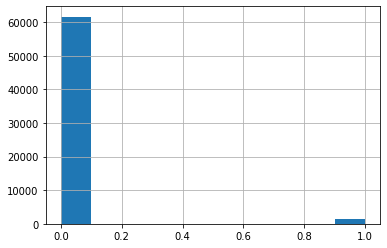

In [4]:
df.query('experimentVariant == 0').purchase.hist() 

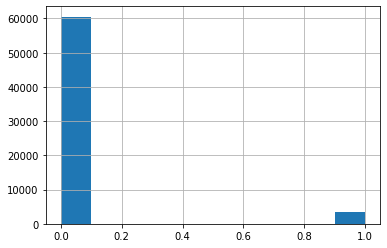

In [5]:
df.query('experimentVariant == 1').purchase.hist()

На первый взгляд и не скажешь, что тут есть проблема со сплитом: в распределениях нет сильных перепадов. Тем не менее, проверка статистической значимости данных эксперимента является целью сейчас, главное - обнаружить проблему при сплитовании!

#### Выполняем A/A тест: сломана ли система сплитования?

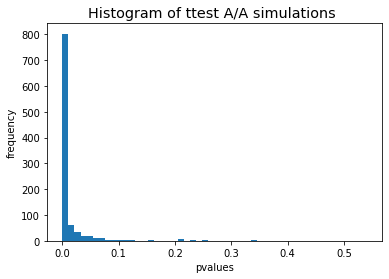

0.929

In [13]:
#выполняем A/A тест
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant == 0').purchase.sample(n_s, replace = False).values
    s2 = df.query('experimentVariant == 1').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

#### Вывод
FPR >0.05, распределение p_value не равномерно, сплит-система сломана. 

С чем это можем быть связано? Смотрим, что происходит с purchase в зависимости от версии приложения

In [7]:
df.groupby(['experimentVariant', 'version']).agg({'uid': 'count', 'purchase': 'mean'})

uid  purchase
experimentVariant version                  
0                 v2.8.0    41283  0.000993
                  v2.9.0    11921  0.074658
                  v3.7.4.0   4204  0.059943
                  v3.8.0.0   5694  0.057604
1                 v2.8.0    41552  0.045606
                  v2.9.0    12033  0.071304
                  v3.7.4.0   4221  0.063018
                  v3.8.0.0   6110  0.062848

Видим, что mean purchase версии 2.8 у контрольной и экспериментальной группы сильно различаются. 

Исключаем проблемную версию 2.8. Проверяем с помощью симуляций, есть ли значимые различия mean purchase по версиям в этом случае

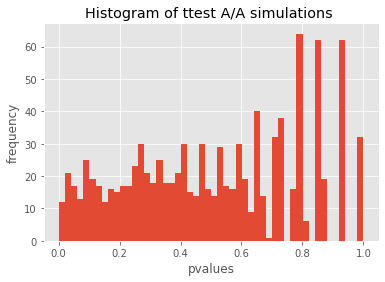

0.038

In [8]:
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant == 0 and version != "v2.8.0"' ).purchase.sample(n_s, replace = False).values
    s2 = df.query('experimentVariant == 1 and version != "v2.8.0"' ).purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

### Вывод:
Мы нашли поломку, проблема в распределении в версии v2.8.0. При исключении  данных v2.8.0 из анализа нулевая гипотеза не 
отклоняется, что позволяет нам сделать вывод о том, что в выборках статистически значимых различий не найдено(p = 0.038, p<0.05)
